# **XGBoost Regressor**

In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import datetime
# Load the data
data = pd.read_csv("product_sales_data.csv")
# Convert the Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])



# Aggregate the data on a weekly basis
data_weekly = data.groupby(['ProductID', pd.Grouper(key='Date', freq='W-MON')]).agg({
    'Sales': 'sum',
    'Price': 'first',  # Assume price remains constant within a week
    'CompetitionPrice': 'first',  # Assume competition price remains constant within a week
    'Holiday':'sum',  # Number of holidays in a week
    'StartingWeek':'sum',# Number of days of starting 7 days in a week i.e:(31,1,2,3,4,5,6 => count will be 6)
    'Weekend':'sum' #Number of sundays and saturdays in week
}).reset_index()


for lag in range(1, 4):  # Add lag features for the previous 3 weeks
    data_weekly[f'Sales_lag_{lag}'] = data_weekly.groupby('ProductID')['Sales'].shift(lag)

# Drop rows with missing values due to lag features
data_weekly.dropna(inplace=True)
data_weekly.head()

,ProductID,Date,Sales,Price,CompetitionPrice,Holiday,StartingWeek,Weekend,Sales_lag_1,Sales_lag_2,Sales_lag_3
3,1,2020-01-27,230.0,160.45,135.00,0,0,2,243.0,261.0,212.5
4,1,2020-02-03,240.5,111.35,113.29,0,3,2,230.0,243.0,261.0
5,1,2020-02-10,270.0,183.83,200.86,1,4,2,240.5,230.0,243.0
6,1,2020-02-17,231.5,134.75,148.05,0,0,2,270.0,240.5,230.0
7,1,2020-02-24,234.0,153.95,153.12,0,0,2,231.5,270.0,240.5


In [2]:
# Select features and target variable
X = data_weekly.drop(['Date', 'Sales'], axis=1)  # Features: Exclude Date and Sales columns
y = data_weekly['Sales']  # Target variable: Sales

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Define the XGBoost model
model = XGBRegressor(objective ='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate Root Mean Squared Percentage Error (RMSPE)
rmspe = np.sqrt(np.mean(np.square((y_test- y_pred) / y_test))) * 100

print(f"Root Mean Squared Percentage Error: {rmspe:.2f}%")

Mean Squared Error: 439.9384756500165
Root Mean Squared Percentage Error: 10.54%


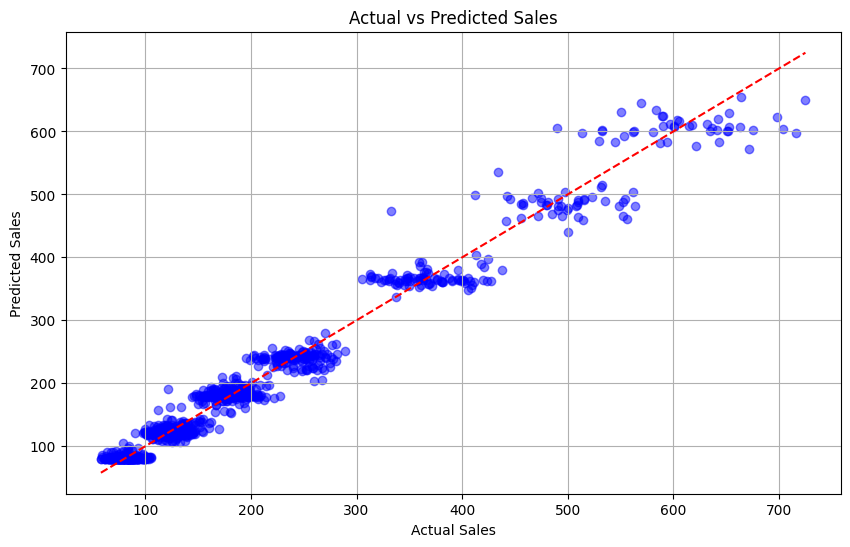

In [3]:
import matplotlib.pyplot as plt

# Plot actual vs predicted sales for test data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Predicted')  # Predicted sales in blue
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')  # Diagonal line in red

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.grid(True)
plt.show()


# **LSTM**

In [6]:
# importing all necessary libraries

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import seaborn as sns

In [9]:
import pandas as pd
import numpy as np
import datetime
# Load the data
data = pd.read_csv("product_sales_data.csv")
# Convert the Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])



# Aggregate the data on a weekly basis
data_weekly = data.groupby(['ProductID', pd.Grouper(key='Date', freq='W-MON')]).agg({
    'Sales': 'sum',
    'Price': 'first',  # Assume price remains constant within a week
    'CompetitionPrice': 'first',  # Assume competition price remains constant within a week
    'Holiday':'sum',  # Number of holidays in a week
    'StartingWeek':'sum',# Number of days of starting 7 days in a week i.e:(31,1,2,3,4,5,6 => count will be 6)
    'Weekend':'sum' #Number of sundays and saturdays in week
}).reset_index()

data_weekly.head()

,ProductID,Date,Sales,Price,CompetitionPrice,Holiday,StartingWeek,Weekend
0,1,2020-01-06,212.5,157.64,175.54,0,6,2
1,1,2020-01-13,261.0,155.09,163.41,0,1,2
2,1,2020-01-20,243.0,147.94,172.30,0,0,2
3,1,2020-01-27,230.0,160.45,135.00,0,0,2
4,1,2020-02-03,240.5,111.35,113.29,0,3,2


<Axes: >

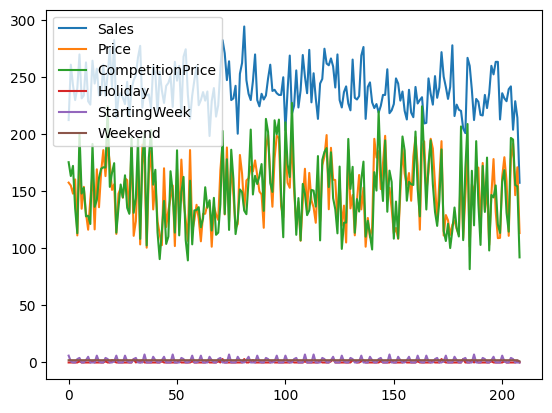

In [11]:
#Now seperating the data product wise as each product has its own sales trends
#Initially training model only for product 1
lstm_data = data_weekly
products = lstm_data['ProductID'].unique()

product_data = lstm_data[lstm_data['ProductID'] == 1].drop(columns=['ProductID'])
product_data.head()

# Graph to show the trend in each feature of data
df_for_training = product_data.drop(columns=['Date'])
df_for_training.plot.line()

trainX shape == (201, 8, 6).
trainY shape == (201, 1).
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 8, 64)             18176     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30625 (119.63 KB)
Trainable params: 30625 (119.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
36/36 [==============================] - 4s 18ms/step - loss: 11864.2568 - val_los

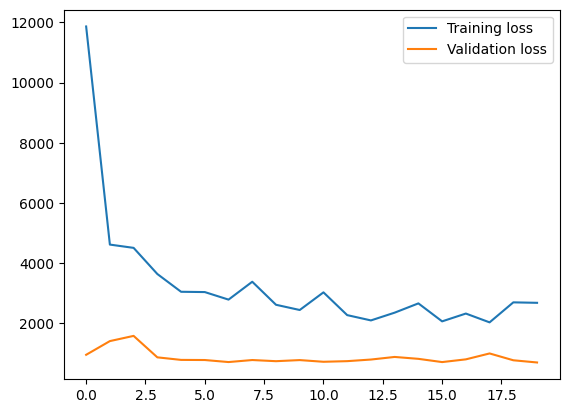

In [16]:
trainX = []
trainY = []

n_future = 1   # Number of weeks we want to look into the future based on the past days.
n_past = 8  # Number of past weeks we want to use to predict the future.

for i in range(n_past, len(df_for_training) - n_future +1):
    trainX.append(df_for_training.iloc[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training.iloc[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))



model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()



history = model.fit(trainX, trainY, epochs=20, batch_size=5, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [17]:
avg_train_loss = np.mean(history.history['loss'])
print("Average training loss:",np.sqrt(avg_train_loss) )

avg_val_loss = np.mean(history.history['val_loss'])
print("Average RMSE validation loss:", np.sqrt(avg_val_loss))

Average training loss: 57.49673118256104
Average RMSE validation loss: 29.403011754235763


# **SARIMAX**

---



In [18]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.2 MB/s eta 0:00:00


In [19]:
import pandas as pd
import numpy as np
import datetime
# Load the data
data = pd.read_csv("product_sales_data.csv")
# Convert the Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])



# Aggregate the data on a weekly basis
data_weekly = data.groupby(['ProductID', pd.Grouper(key='Date', freq='W-MON')]).agg({
    'Sales': 'sum',
    'Price': 'first',  # Assume price remains constant within a week
    'CompetitionPrice': 'first',  # Assume competition price remains constant within a week
    'Holiday':'sum',  # Number of holidays in a week
    'StartingWeek':'sum',# Number of days of starting 7 days in a week i.e:(31,1,2,3,4,5,6 => count will be 6)
    'Weekend':'sum' #Number of sundays and saturdays in week
}).reset_index()

data_weekly.head()

,ProductID,Date,Sales,Price,CompetitionPrice,Holiday,StartingWeek,Weekend
0,1,2020-01-06,212.5,157.64,175.54,0,6,2
1,1,2020-01-13,261.0,155.09,163.41,0,1,2
2,1,2020-01-20,243.0,147.94,172.30,0,0,2
3,1,2020-01-27,230.0,160.45,135.00,0,0,2
4,1,2020-02-03,240.5,111.35,113.29,0,3,2


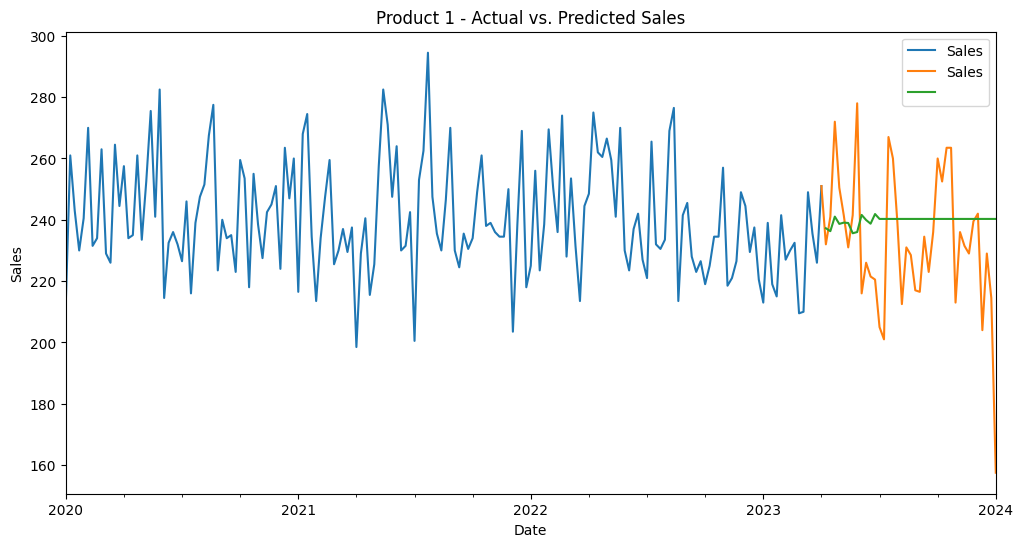

RMSPE for each product: [12.180570988603414]


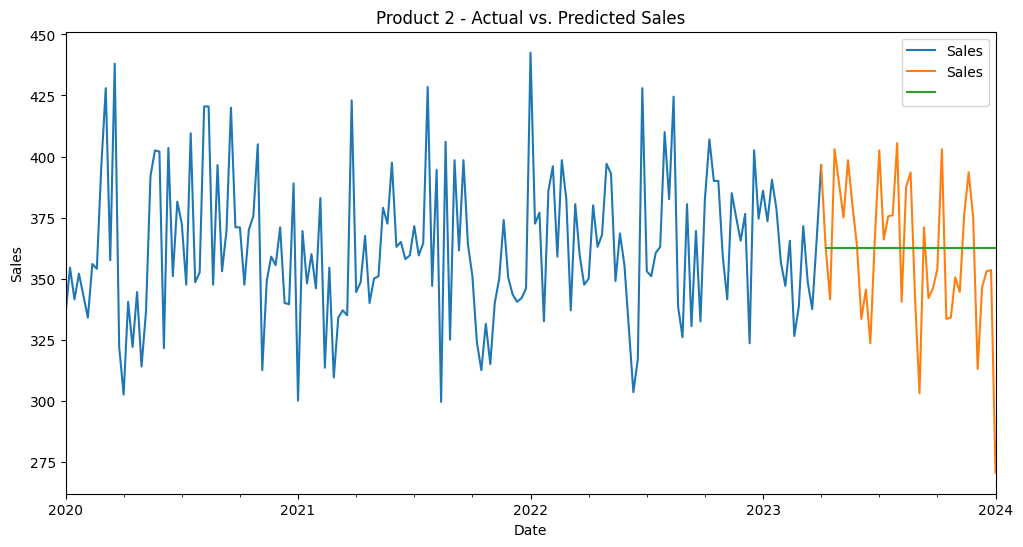

RMSPE for each product: [12.180570988603414, 9.114630102291686]


In [23]:
from pmdarima import auto_arima
import numpy as np

sar_data=data_weekly
products = sar_data['ProductID'].unique()
products=products[:2]  #currnetly training model only for two products
errors = []
# We can can not train model for all products together as sarimax use date index, product 1 and product 2 could be both soldat same date hence
#index would become repitive
for product in products:
    product_data = sar_data[sar_data['ProductID'] == product].drop(columns=['ProductID'])

    product_data['Date'] = pd.to_datetime(product_data['Date'])
    product_data.set_index('Date', inplace=True)
    train_X = product_data.iloc[:-39, 1:]
    train_Y = product_data.iloc[:-39, 0]
    test_X = product_data.iloc[-40:, 1:]
    test_Y = product_data.iloc[-40:, 0]

    # Fit SARIMA model
    sar_model = auto_arima(y=train_Y, exogenous=train_X, m=12)

    # Make predictions
    y_pred = pd.Series(sar_model.predict(n_periods=119, X=test_X), index=test_Y.index)

    # Calculate RMSPE
    rmspe = np.sqrt(np.mean(np.square((test_Y - y_pred) / test_Y))) * 100
    errors.append(rmspe)

    # Plot actual vs. predicted
    plt.figure(figsize=(12, 6))
    train_Y.plot(legend=True)
    test_Y.plot(legend=True)
    y_pred.plot(legend=True)
    plt.title(f"Product {product} - Actual vs. Predicted Sales")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.show()

    print("RMSPE for each product:", errors)


In [24]:
import statistics
mean_error=statistics.mean(errors)
print('Mean error : ',mean_error)

Mean error :  10.647600545447549


# **Multi variate Prophet**

In [25]:
import pandas as pd
import numpy as np
import datetime
# Load the data
data = pd.read_csv("product_sales_data.csv")
# Convert the Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])



# Aggregate the data on a weekly basis
data_weekly = data.groupby(['ProductID', pd.Grouper(key='Date', freq='W-MON')]).agg({
    'Sales': 'sum',
    'Price': 'first',  # Assume price remains constant within a week
    'CompetitionPrice': 'first',  # Assume competition price remains constant within a week
    'Holiday':'sum',  # Number of holidays in a week
    'StartingWeek':'sum',# Number of days of starting 7 days in a week i.e:(31,1,2,3,4,5,6 => count will be 6)
    'Weekend':'sum' #Number of sundays and saturdays in week
}).reset_index()

data_weekly.head()

,ProductID,Date,Sales,Price,CompetitionPrice,Holiday,StartingWeek,Weekend
0,1,2020-01-06,212.5,157.64,175.54,0,6,2
1,1,2020-01-13,261.0,155.09,163.41,0,1,2
2,1,2020-01-20,243.0,147.94,172.30,0,0,2
3,1,2020-01-27,230.0,160.45,135.00,0,0,2
4,1,2020-02-03,240.5,111.35,113.29,0,3,2


In [27]:
from prophet import Prophet

prop_data = data_weekly
products = prop_data['ProductID'].unique()   # training seperately for each product as prophet is time series model
products=products[:1] # training for only one product as prophet is time series model
product_data = prop_data[sar_data['ProductID'] == product].drop(columns=['ProductID'])

# splitting train and test data

train= product_data.iloc[:-39,:]
test= product_data.iloc[-40:,:]

df=train

In [30]:
train = train.rename(columns={'Sales': 'y', 'Date':'ds'})
train['y_orig'] = train['y']
train['y'] = np.log(train['y'])

# Adding regression for all other features other than dates to predict sales
model_new = Prophet()
model_new.add_regressor('Price')
model_new.add_regressor('CompetitionPrice')
model_new.add_regressor('Holiday')
model_new.add_regressor('StartingWeek')
model_new.add_regressor('Weekend')


In [31]:
model_new.fit(train)
future_data = model_new.make_future_dataframe(periods=12, freq = 'W')

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps_d3ktnw/keenz5uo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps_d3ktnw/vfoucff1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50955', 'data', 'file=/tmp/tmps_d3ktnw/keenz5uo.json', 'init=/tmp/tmps_d3ktnw/vfoucff1.json', 'output', 'file=/tmp/tmps_d3ktnw/prophet_modelpgfx8x5a/prophet_model-20240429205733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:57:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:57:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [44]:
product_data = product_data.rename(columns={'Sales': 'y', 'Date':'ds'})
future_data=product_data[['ds', 'Price', 'CompetitionPrice','Holiday','StartingWeek','Weekend']]
future_data.head(5)

,ds,Price,CompetitionPrice,Holiday,StartingWeek,Weekend
209,2020-01-06,173.43,171.59,0,6,2
210,2020-01-13,282.91,265.68,0,1,2
211,2020-01-20,233.19,199.75,0,0,2
212,2020-01-27,194.81,228.45,0,0,2
213,2020-02-03,156.48,131.88,0,3,2


In [34]:
forecast_data = model_new.predict(future_data)

forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
204,2023-12-04,1.775079,1.759357,1.791895
205,2023-12-11,1.770033,1.753219,1.785358
206,2023-12-18,1.771840,1.756626,1.788093
207,2023-12-25,1.781214,1.765679,1.797649
208,2024-01-01,1.774579,1.758350,1.790494


In [35]:
forecast_data

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,CompetitionPrice,CompetitionPrice_lower,CompetitionPrice_upper,Holiday,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-06,1.760824,1.756399,1.788557,1.760824,1.760824,0.000539,0.000539,0.000539,-0.001624,...,0.006495,0.006495,0.006495,0.004664,0.004664,0.004664,0.0,0.0,0.0,1.771984
1,2020-01-13,1.760968,1.756384,1.789012,1.760968,1.760968,-0.000375,-0.000375,-0.000375,-0.001624,...,0.007826,0.007826,0.007826,0.003579,0.003579,0.003579,0.0,0.0,0.0,1.772373
2,2020-01-20,1.761111,1.755475,1.786639,1.761111,1.761111,0.000266,0.000266,0.000266,-0.001624,...,0.008927,0.008927,0.008927,0.000929,0.000929,0.000929,0.0,0.0,0.0,1.770968
3,2020-01-27,1.761255,1.752017,1.784456,1.761255,1.761255,-0.000013,-0.000013,-0.000013,-0.001624,...,0.008654,0.008654,0.008654,-0.000785,-0.000785,-0.000785,0.0,0.0,0.0,1.769124
4,2020-02-03,1.761398,1.752264,1.783828,1.761398,1.761398,0.000925,0.000925,0.000925,-0.001624,...,0.008241,0.008241,0.008241,-0.001528,-0.001528,-0.001528,0.0,0.0,0.0,1.768111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2023-12-04,1.767626,1.759357,1.791895,1.765814,1.769245,0.000142,0.000142,0.000142,-0.001624,...,0.006996,0.006996,0.006996,0.000457,0.000457,0.000457,0.0,0.0,0.0,1.775079
205,2023-12-11,1.767665,1.753219,1.785358,1.765760,1.769369,-0.001048,-0.001048,-0.001048,-0.001624,...,0.006247,0.006247,0.006247,-0.003879,-0.003879,-0.003879,0.0,0.0,0.0,1.770033
206,2023-12-18,1.767704,1.756626,1.788093,1.765710,1.769513,0.000440,0.000440,0.000440,-0.001624,...,0.009108,0.009108,0.009108,-0.004972,-0.004972,-0.004972,0.0,0.0,0.0,1.771840
207,2023-12-25,1.767743,1.765679,1.797649,1.765695,1.769615,0.000130,0.000130,0.000130,0.004510,...,0.014922,0.014922,0.014922,-0.001450,-0.001450,-0.001450,0.0,0.0,0.0,1.781214


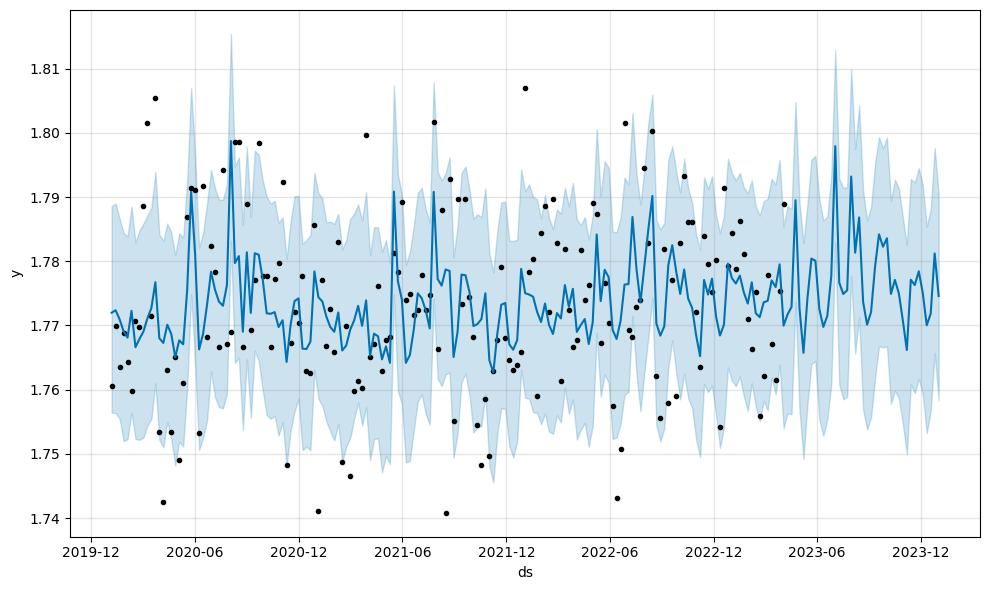

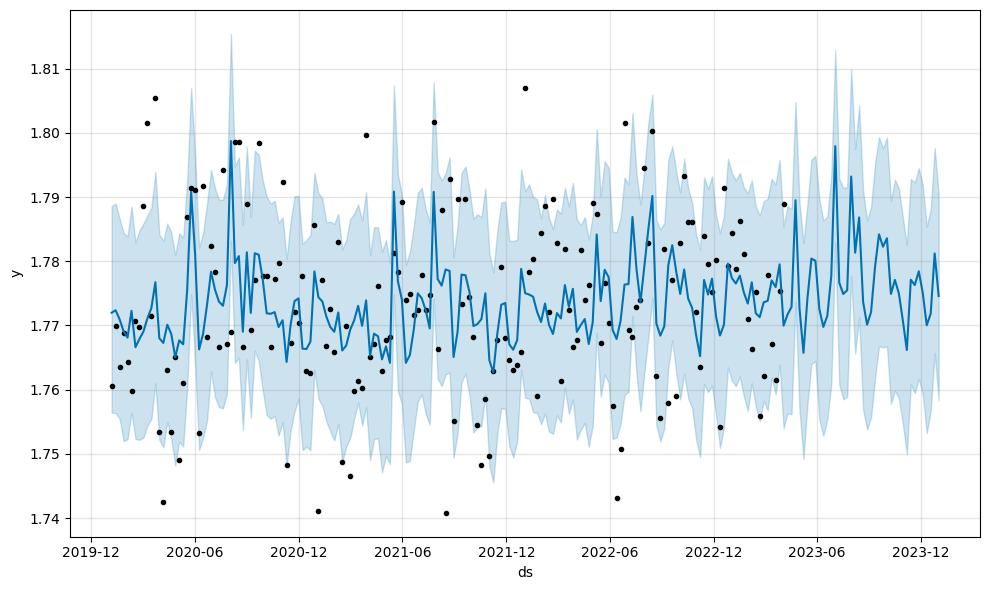

In [36]:
model_new.plot(forecast_data)

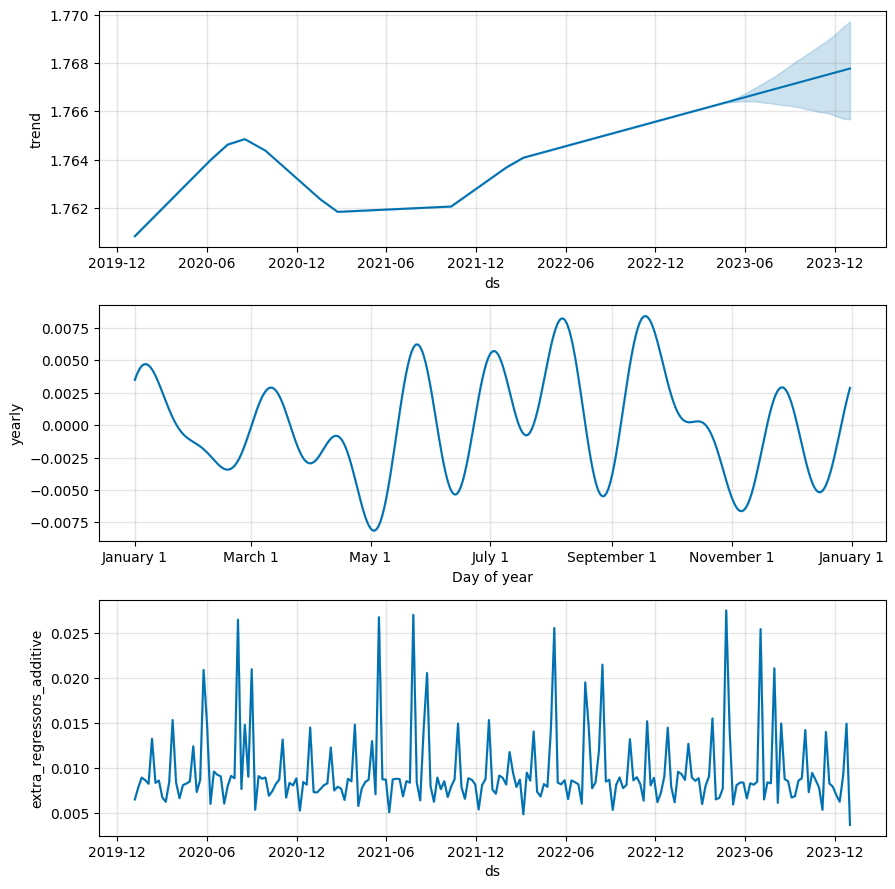

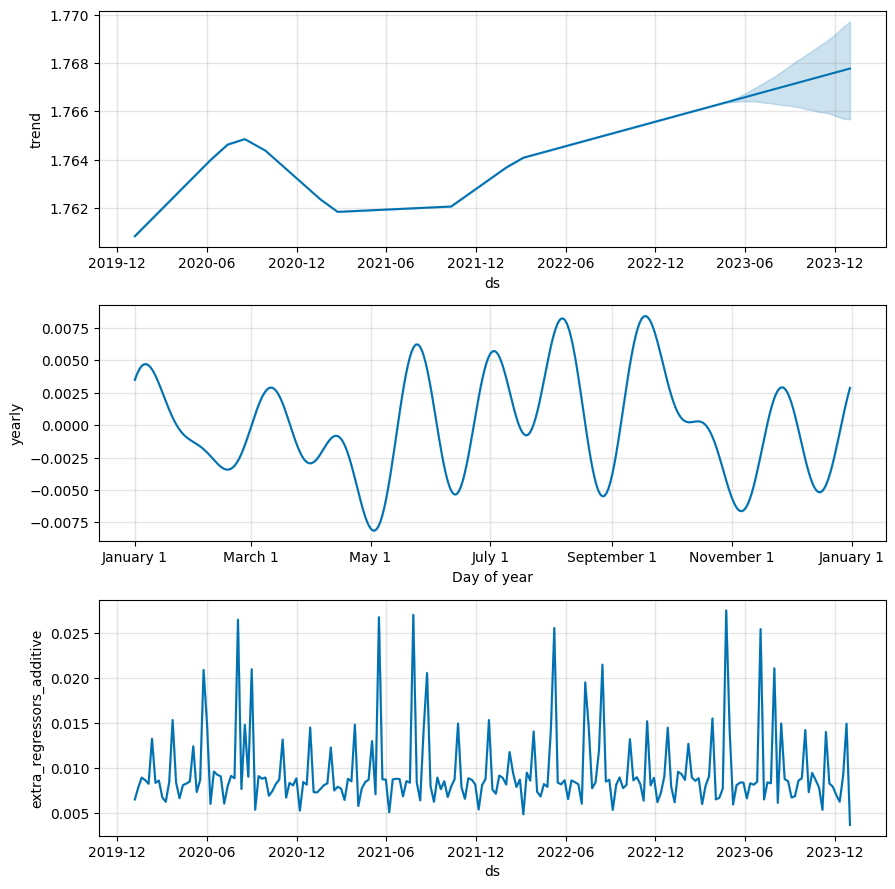

In [37]:
model_new.plot_components(forecast_data)

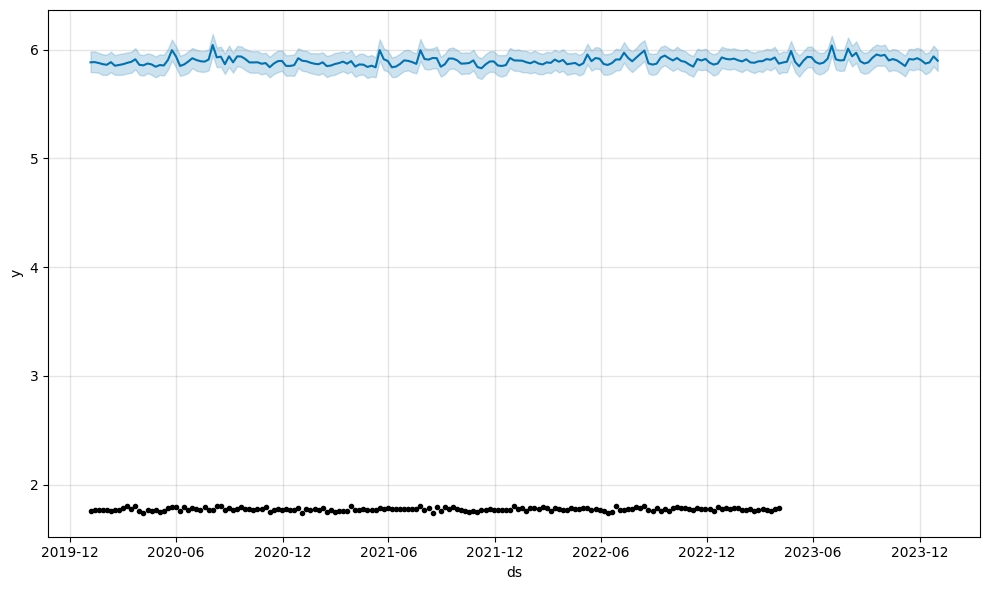

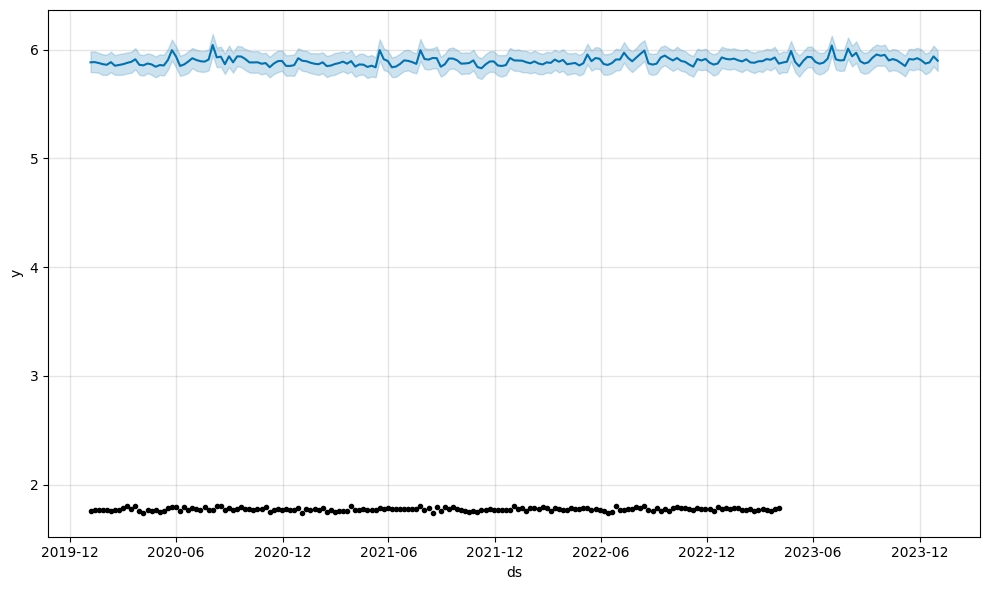

In [40]:
forecast_data_orig = forecast_data # make sure we save the original forecast data
forecast_data_orig['yhat'] = np.exp(forecast_data_orig['yhat'])
forecast_data_orig['yhat_lower'] = np.exp(forecast_data_orig['yhat_lower'])
forecast_data_orig['yhat_upper'] = np.exp(forecast_data_orig['yhat_upper'])

model_new.plot(forecast_data_orig)

In [41]:
train['y_log']=train['y']
train['y']=train['y_orig']

In [42]:
final_df = pd.DataFrame(forecast_data_orig)
import plotly.graph_objs as go
import plotly.offline as py
#Plot predicted and actual line graph with X=dates, Y=Outbound
actual_chart = go.Scatter(y=train["y_orig"], name= 'Actual')
predict_chart = go.Scatter(y=final_df["yhat"], name= 'Predicted')
predict_chart_upper = go.Scatter(y=final_df["yhat_upper"], name= 'Predicted Upper')
predict_chart_lower = go.Scatter(y=final_df["yhat_lower"], name= 'Predicted Lower')
py.plot([actual_chart, predict_chart, predict_chart_upper, predict_chart_lower])

'temp-plot.html'